# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
# Standard Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# NLP imports

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import string
import re

In [3]:
# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Utility import

from util import evaluate_model

In [5]:
# Download stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreymarvel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Set Pandas options
pd.set_option('display.max_colwidth', None)

In [7]:
# Import data

df = pd.read_csv('./../../Data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

In [8]:
# Change column names to something more readable

df.columns = ['tweet', 'product/company', 'emotion']

In [9]:
df.head(5)

,tweet,product/company,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [10]:
# Explore distribution of target variable. 60% are netural, 33% are positive, and only 6% are negative

df['emotion'].value_counts(normalize = True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [11]:
# Explore nulls in tweets. There is one blank tweet.

df.isna().sum()

tweet                 1
product/company    5802
emotion               0
dtype: int64

In [12]:
# Explore nulls for where product / company is null
# Most of the nulls for product / company are neutral

no_brand = df[df['product/company'].isna()]

no_brand['emotion'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

In [13]:
no_brand.head(50)

,tweet,product/company,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
35,"At #sxsw. Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}",NaN,No emotion toward brand or product
37,SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention,NaN,No emotion toward brand or product
39,VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw,NaN,No emotion toward brand or product
41,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}",NaN,No emotion toward brand or product


In [14]:
# Almost all of the "can't tell" emotions do not have a product associated with them.
# Plan is to drop these rows unless we can fill in some of the values with Text Blob

cant_tell = df[df['emotion'] == "I can't tell"]

cant_tell['product/company'].isna().sum() / cant_tell.shape[0]

0.9423076923076923

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [15]:
# Drop the single null tweet

df = df.dropna(subset=['tweet'])

In [16]:
# Clean tweets to prepare for tokenizing

def clean_tweets(text):
    
    clean_text = text
    
    # These characters appear in place of an apostrophe
    clean_text = clean_text.replace('Ûª', "'")
    
    # Remove punctuation
    clean_text = clean_text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove links
    clean_text = re.sub(r'(http://[^"\s]+)|(@\w+)', '', clean_text)
    clean_text = re.sub(r'(https://[^"\s]+)|(@\w+)', '', clean_text)
    
    # Remove handles
    clean_text = re.sub("@[A-Za-z0-9]+", '' , clean_text)

    # Remove hastag but keep the words
    clean_text = re.sub(r'#', '', clean_text)
    
    # Remove SXSW from tweet
    clean_text = clean_text.replace('sxsw', '')
    clean_text = clean_text.replace('SXSW', '')
    
    # Make everything lowercase
    clean_text = clean_text.lower()
#     [word.lower() for word in clean_text.split(' ')]
     
    return clean_text

In [17]:
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_tweets(x))

In [18]:
df.head()

,tweet,product/company,emotion,clean_tweet
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeting at riseaustin it was dead i need to upgrade plugin stations at
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they should sale them down at
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as this years iphone app
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,sxtxstate great stuff on fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress


In [19]:
# Tokenize the clean tweet column

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)


In [20]:
df['tokenized'] = df['clean_tweet'].apply(lambda x: tokenizer.tokenize(x))

In [21]:
df.head()

,tweet,product/company,emotion,clean_tweet,tokenized
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeting at riseaustin it was dead i need to upgrade plugin stations at,"[wesley, i, have, a, g, iphone, after, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they should sale them down at,"[swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as this years iphone app,"[i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,sxtxstate great stuff on fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[sxtxstate, great, stuff, on, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]"


In [22]:
# Try to fill in missing product/company

def fill_brand(token_text):
    
    apple_keywords = ['Apple', 'apple', 'iPhone', 'iPad', 'iTunes']
    google_keywords = ['Google', 'google', 'Android', 'android']
    
    temp_apple = [word for word in token_text if word in apple_keywords]
    temp_google = [word for word in token_text if word in google_keywords]
    
    if (len(temp_apple) > 0) & (not temp_google):
        return 'Apple'
    elif (not temp_apple) & (len(temp_google) > 0):
        return 'Google'
    elif (len(temp_apple) > 0) & (len(temp_google) > 0):
        return 'Both'
    else:
        return np.nan

In [23]:
df['brand'] = df['tokenized'].apply(lambda x: fill_brand(x))

df['brand'].value_counts()

Google    2668
Apple     1926
Both        29
Name: brand, dtype: int64

In [24]:
# Fill in missing brands

df['product/company'].fillna(df['brand'], inplace=True)

In [25]:
# Remove stop words

stopword_list = stopwords.words('english') + list(string.punctuation)

In [26]:
# Drop can't tell values from emotion column

df = df[df['emotion'] != "I can't tell"]

df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [27]:
# Create a sentiment target and map it

target_map = {'Positive emotion': 2,
              'No emotion toward brand or product': 1,
              'Negative emotion': 0}

# Map it
df['sentiment'] = df['emotion'].map(target_map)

In [28]:
df.head()

,tweet,product/company,emotion,clean_tweet,tokenized,brand,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeting at riseaustin it was dead i need to upgrade plugin stations at,"[wesley, i, have, a, g, iphone, after, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at]",NaN,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at]",NaN,2
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they should sale them down at,"[swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at]",NaN,2
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as this years iphone app,"[i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app]",NaN,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,sxtxstate great stuff on fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[sxtxstate, great, stuff, on, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",Google,2


## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

In [29]:
# First model is simple multinomial naive bayes

# Define our X and y
X = df['clean_tweet']
y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
vectorizer = TfidfVectorizer(
    max_df=.95,  # removes words that appear in more than 95% of docs
    min_df=2 # removes words that appear 2 or fewer times
)  

In [31]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [32]:
clf = MultinomialNB()

clf.fit(X_train_vec, y_train)

clf.score(X_test_vec, y_test)

0.6602506714413607

Accuracy: 0.6603
Precision: 0.6364
Recall: 0.6603
F1 Score: 0.6012
ROC: nan


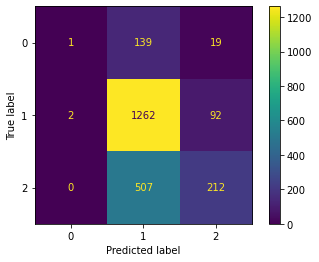

In [33]:
acc, prec, recall, f1 = evaluate_model(clf, X_test_vec, y_test, plot_cf = True)

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [34]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [35]:
# code here for your first 'substandard' model

In [36]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [37]:
# code here to iteratively improve your models

In [38]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [39]:
# code here to show your final model

In [40]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
